## Statistics and Results Notebook! ##

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [48]:
def ParseMetrics(fileName, dir):
    parsedData = {}
    
    fullPath = f"{dir}\{fileName}"
    
    df = pd.read_csv(fullPath)
    # print(df.head())
    # print(df.iloc[0]['Value'])
    
    # 1. Nodal Efficiency
    nodalString = df.iloc[0]['Value']
    valueDict = {}
    for item in nodalString.split(';'):
        if item.strip():  # Ignore empty strings
            key, val = item.split(':')
            valueDict[int(key.strip())] = float(val.strip())

    parsedData['Nodal Efficiency'] = valueDict
    
    # 2. Global Efficiency
    globalEfficiency = float(df.iloc[1]['Value'])
    parsedData['Global Efficiency'] = globalEfficiency
    
    # 3. Degree Centrality
    degreeCentralityString = df.iloc[2]['Value']
    degreeValueDict = {}
    for item in degreeCentralityString.split(';'):
        if item.strip():
            key, value = item.split(':')
            degreeValueDict[int(key.strip())] = float(value.strip())
    
    parsedData['Degree Centrality'] = degreeValueDict
    
    # 4. Average Clustering Coefficient
    averageClustering = float(float(df.iloc[5]['Value']))
    parsedData['Average Clustering'] = averageClustering
    
    return parsedData
    
    

<string>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\{'
<string>:4: SyntaxWarning: invalid escape sequence '\{'
<>:4: SyntaxWarning: invalid escape sequence '\{'
C:\Users\mattm\AppData\Local\Temp\ipykernel_46184\2367837008.py:4: SyntaxWarning: invalid escape sequence '\{'
  fullPath = f"{dir}\{fileName}"


In [49]:
def ParsePhenotypicData(fileName, pathToPhenotypicCSV):
    phenotypicData = {}
    df = pd.read_csv(pathToPhenotypicCSV)
    
    
    resultRow = df[df['FILE_ID'] == fileName]
    
    if not resultRow.empty:
        # Define the columns you want to check and assign
        columns_to_check = ['FIQ', 'HANDEDNESS_CATEGORY', 'AGE_AT_SCAN', 'SEX']

        for col in columns_to_check:
            # Check if the value is NaN and handle accordingly
            if pd.isna(resultRow[col].values[0]):  # Check for NaN
                if col in ['FIQ', 'AGE_AT_SCAN', 'SEX']:  # Numeric columns
                    phenotypicData[col] = -9999
                else:  # Non numeric values 'empty'
                    phenotypicData[col] = "Unknown"
            else:
                if col in ['FIQ', 'AGE_AT_SCAN', 'SEX']:  # Numeric columns
                    phenotypicData[col] = float(resultRow[col].values[0])
                else:  # Non-numeric columns
                    phenotypicData[col] = resultRow[col].values[0]

        phenotypicData['DX_GROUP'] = resultRow['DX_GROUP'].values[0]
    return phenotypicData
    
    # print(df.head())

In [50]:
def FindNodesFromBrodmanns(ba_nums: list, pathToMapping):
    df = pd.read_csv(pathToMapping)
    # print(df.head())
    
    results = {}
    for ba in ba_nums:
        
        matchingRows = df[df['ba.label'].str.extract(r'(\d+)')[0].astype(int) == ba]
        
        roiNums = matchingRows['ROI number'].tolist()
        results[ba] = roiNums
        
    return results

In [95]:
import os
metricsDir =  R"C:\GIT\Connectomics\Research_Project\Binary_Notebooks\Binary_Output\25%\NetworkMetrics"
pathToPheno = R"C:\GIT\Connectomics\Research_Project\Phenotypic_V1_0b_preprocessed1.csv"

# strippedFileName = "Leuven_2_0050722"

fileNames = os.listdir(metricsDir)

columns = [
    "Node", "Participant", "IQ", "Age", "Handedness", "Sex", 
    "Nodal EFficiency", "Global Efficiency", "Average Clustering", "Degree Centrality"
]




# node = 83

ba_nums = [6, 7, 9, 10, 18, 19, 21, 37, 39, 40, 45, 46, 47]
pathToMap = R"C:\GIT\Connectomics\Research_Project\labeled_regions_ba.csv"

brodmannMapping = FindNodesFromBrodmanns(ba_nums, pathToMap) # Provides a mapping between ba: nodes that overlap
print(brodmannMapping)
# print(brodmannMapping)
# THIS IS MESSED UP!


for ba, nodes in brodmannMapping.items():
    results_df = pd.DataFrame(columns=columns)
    dataframes = []
    # key is the ba, value is a list containing CC400 nodes mapping to said ba
    print(ba, nodes)
    
    # For each node
    # for filename in files
    for metricsFileName in fileNames:
        
        
        nodeMetrics = {
        "Nodal Efficiency" : [],
        "Global Efficiency" : [],
        "Average Clustering" : [],
        "Degree Centrality" : []
                    }
        
        strippedFileName = metricsFileName.split('_rois')[0]
        metrics = ParseMetrics(metricsFileName, metricsDir)
        phenotypic = ParsePhenotypicData(strippedFileName, pathToPheno)
        validParticipant = True
        
        for key, value in phenotypic.items():
            if value == -9999 or value == "Unknown" or metrics['Average Clustering'] == 0:
                validParticipant = False
        
        if validParticipant:
        
            for node in nodes:
                nodeMetrics['Nodal Efficiency'].append(metrics.get('Nodal Efficiency', -9999)[node])
                nodeMetrics['Global Efficiency'].append(metrics.get('Global Efficiency', -9999))
                nodeMetrics['Average Clustering'].append(metrics.get("Average Clustering", -9999))
                nodeMetrics['Degree Centrality'].append(metrics.get("Degree Centrality", -9999)[node])
            
        # Great, we have collected all nodes in the ba mapping, let's average them.
        # print(metricsFileName, nodeMetrics)
        
        # Now, we want to average the metrics
        
        averagedMetrics = {}
        if nodeMetrics['Nodal Efficiency'] == []:
            print("Skipping!")
            
        else:
            for key, value in nodeMetrics.items():
                averagedMetrics[key] = np.mean(value)
        
        # Now, we can store as a df
        if nodeMetrics['Nodal Efficiency'] != [] and validParticipant:
            temp_df = pd.DataFrame([{
                "Participant" : strippedFileName,
                "Brodmann's Area" : ba,
                "DX_GROUP" : phenotypic.get("DX_GROUP", "N/A"),
                "IQ" : phenotypic.get("FIQ", "N/A"),
                "Age": phenotypic.get("AGE_AT_SCAN", "N/A"),
                "Handedness": phenotypic.get("HANDEDNESS_CATEGORY", "N/A"),
                "Sex": phenotypic.get("SEX", "N/A"),
                "Nodal Efficiency" : averagedMetrics.get("Nodal Efficiency"),
                "Global Eff": averagedMetrics.get("Global Efficiency", "N/A"),
                "Clustering": averagedMetrics.get("Average Clustering", "N/A"),
                "Degree Centrality": averagedMetrics.get("Nodal Efficiency")
            }])
            dataframes.append(temp_df)
    results_df = pd.concat(dataframes, ignore_index=True)
    outputString = "BA/25%/output_ba_" + str(ba) + ".csv"
    results_df.to_csv(outputString, index=False)
    
    
# results_df = results_df.append({'Node' : node})
# for each node in keys
# for metricsFileName in fileNames:
#     strippedFileName = metricsFileName.split('_rois')[0]
    
#     metrics = ParseMetrics(metricsFileName, metricsDir)
#     phenotypic = ParsePhenotypicData(strippedFileName, pathToPheno)
    
#     # Validate Participant Based on Inclusion Criteria
    
#     validParticipant = True
#     for key, value in phenotypic.items():
#         if value == -9999:
#             validParticipant = False
            
#         if value == "Unknown":
#             validParticipant = False
            
#     # if phenotypic['AGE_AT_SCAN'] < 18 or phenotypic['AGE_AT_SCAN'] > 45:
#     #     validParticipant = False
#     #     print("AGE RELEASED")
    
#     # if phenotypic['HANDEDNESS_CATEGORY'] == -9999:
#     #     validParticipant = False
    
#     if metrics['Average Clustering'] == 0:
#         validParticipant = False
        
#     if validParticipant:
        
#         temp_df = pd.DataFrame([{
#             "Participant" : strippedFileName,
#             "Node" : node,
#             "DX_GROUP" : phenotypic.get("DX_GROUP", "N/A"),
#             "IQ" : phenotypic.get("FIQ", "N/A"),
#             "Age": phenotypic.get("AGE_AT_SCAN", "N/A"),
#             "Handedness": phenotypic.get("HANDEDNESS_CATEGORY", "N/A"),
#             "Sex": phenotypic.get("SEX", "N/A"),
#             "Nodal Efficiency" : metrics.get("Nodal Efficiency")[node],
#             "Global Eff": metrics.get("Global Efficiency", "N/A"),
#             "Clustering": metrics.get("Average Clustering", "N/A"),
#             "Degree Centrality": metrics.get("Nodal Efficiency")[node]
#         }])
#         dataframes.append(temp_df)
#     else:
#         print(f"Excluding Participant: {strippedFileName}")
        
        
# results_df = pd.concat(dataframes, ignore_index=True)
# results_df.to_csv("output_node83_age18-45.csv", index=False)

    



{6: [7, 16, 28, 56, 72, 81, 113, 129, 145, 147, 150, 159, 165, 167, 174, 187, 210, 215, 241, 281, 291, 293, 304, 316, 334, 345, 352, 393], 7: [51, 61, 104, 118, 181, 211, 240, 263, 275, 287, 323, 327, 355, 360, 376, 381], 9: [53, 88, 96, 116, 178, 212, 249, 265, 279, 289, 386, 400], 10: [2, 60, 80, 84, 106, 142, 160, 172, 190, 202, 232, 235, 254, 264, 297, 379, 387, 392, 397], 18: [24, 43, 58, 62, 63, 76, 78, 92, 114, 136, 144, 151, 176, 180, 204, 225, 253, 269, 286, 318, 321, 332, 340, 351, 353, 362, 367, 378], 19: [1, 6, 13, 18, 26, 27, 37, 70, 105, 108, 146, 169, 173, 183, 219, 229, 231, 234, 282, 294, 295, 301, 326, 335, 357, 372, 377], 21: [36, 52, 57, 69, 155, 197, 209, 228, 280, 364, 374], 37: [17, 41, 55, 83, 94, 97, 110, 119, 127, 134, 175, 179, 188, 195, 218, 227, 230, 247, 251, 258, 259, 276, 278, 290, 296, 310, 315, 322, 346, 349, 361], 39: [8, 30, 73, 120, 135, 138, 141, 164, 189, 207, 217, 252, 308, 314, 319, 341, 356, 395], 40: [49, 65, 68, 102, 115, 199, 206, 237, 250, 

__Averaging Brodmann's regions Metrics__

output_ba_10.csv
output_ba_18.csv
output_ba_19.csv
output_ba_21.csv
output_ba_37.csv
output_ba_39.csv
output_ba_40.csv
output_ba_45.csv
output_ba_46.csv
output_ba_47.csv
output_ba_6.csv
output_ba_7.csv
output_ba_9.csv


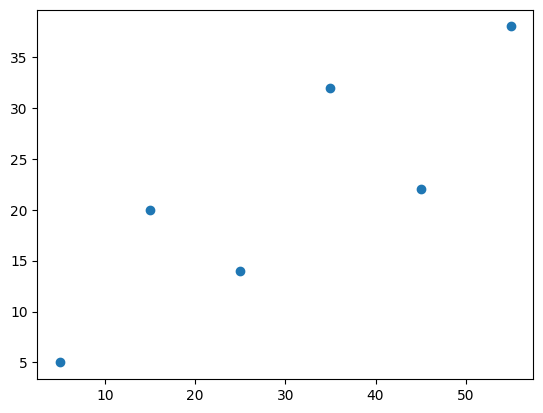

0.7158756137479542


In [3]:
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape(-1, 1)
y = np.array([5, 20, 14, 32, 22, 38])

import matplotlib.pyplot as plt

# PER NODE
# x --> fiq
# y --> degree centrality 
# covariates

# for each participant:
#   regression(x, y) <-- y is constant
#   store .score()

# NOTES:

# 1. Only include NT
# 2. Only include with recorded FSIQ, AGE, SEX, HANDEDNESS
# 3. (Double check 0.0 for all values)
# 4. 


plt.scatter(x, y)
plt.show()

model = LinearRegression()
model.fit(x, y)

r_sq = model.score(x, y)
print(r_sq)

In [ ]:
import os
from glob import glob

folders = ["10%", "15%", "20%", "25%", "30%"]

file_list = [os.path.basename(file) for file in glob(os.path.join(folders[0], "*.csv"))]

for fileName in file_list:
    dfs = []
    for folder in folders:
        file_path = os.path.join(folder, fileName)
        if os.path.exists(file_path):
            dfs.append(pd.read_csv(file_path))
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    numeric_columns = ["Nodal Efficiency", "Global Eff", "Clustering", "Degree Centrality"]
    averaged_numeric = combined_df.groupby("Participant")[numeric_columns].mean().reset_index()

    # Retain non-numeric columns from the first file
    non_numeric_columns = ["Participant", "Brodmann's Area", "DX_GROUP", "IQ", "Age", "Handedness", "Sex"]
    non_numeric_data = combined_df[non_numeric_columns].drop_duplicates(subset="Participant")

    # Merge the numeric averages with non-numeric data
    final_df = pd.merge(non_numeric_data, averaged_numeric, on="Participant")
    
    
    averaged_csv_path = os.path.join("averaged", fileName)
    final_df.to_csv(averaged_csv_path, index=False)

## Linear Regression ##

583
                            OLS Regression Results                            
Dep. Variable:       Nodal Efficiency   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.998
Date:                Sat, 23 Nov 2024   Prob (F-statistic):              0.122
Time:                        14:39:18   Log-Likelihood:                 87.491
No. Observations:                  74   AIC:                            -167.0
Df Residuals:                      70   BIC:                            -157.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6681      0.135      4.935     

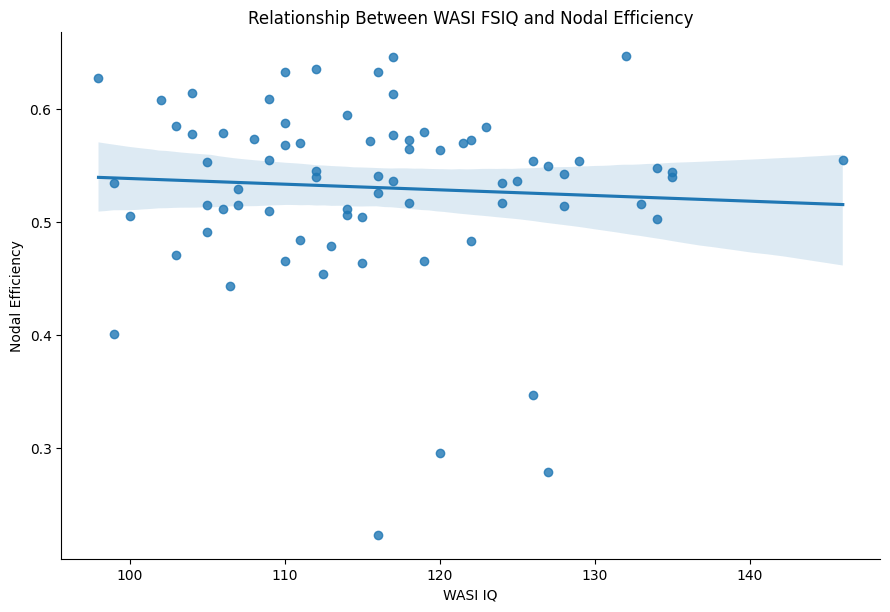

In [45]:
# Step 1: Load the data

import statsmodels.api as sm

file_path = "BA/averaged/output_ba_45.csv"  # Replace with your actual CSV file path
data = pd.read_csv(file_path)

print(len(data))

filtered_data = data[data['DX_GROUP']  == 2]
filtered_data = filtered_data[filtered_data['Age'] >= 18]
filtered_data = filtered_data[filtered_data['Age'] <= 30]


y = filtered_data['Nodal Efficiency']
X = filtered_data[['IQ', 'Age', 'Sex']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

# Scatter plot with regression line
sns.lmplot(
    x="IQ", y="Nodal Efficiency", data=filtered_data, palette="Set1", height=6, aspect=1.5
)
plt.title("Relationship Between WASI FSIQ and Nodal Efficiency")
plt.xlabel("WASI IQ")
plt.ylabel("Nodal Efficiency")
plt.show()